### calling packages

In [1]:
import os

import numpy as np
import tensorflow as tf
import keras as K

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.optimize import curve_fit


In [2]:
#import multiprocessing
#multiprocessing.cpu_count()

### K and tf version

In [3]:
import sys
print(sys.version)
print(sys.version_info)
print("\n K:  ", K.__version__)
print("\n tf: ", tf.__version__)

print("\n")
!jupyter --version

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:15:57) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)

 K:   2.10.0

 tf:  2.10.0


Selected Jupyter core packages...
IPython          : 8.20.0
ipykernel        : 6.28.0
ipywidgets       : 8.1.2
jupyter_client   : 8.6.0
jupyter_core     : 5.5.0
jupyter_server   : 2.10.0
jupyterlab       : 4.0.11
nbclient         : 0.8.0
nbconvert        : 7.10.0
nbformat         : 5.9.2
notebook         : 7.0.8
qtconsole        : 5.5.1
traitlets        : 5.7.1


### KMC constants

In [13]:
# thermal energy (eV)
kT = 0.025
#~~~~~~~~~~~~~~~~~~~~~~
# disorder strength range
if_exp = 0
sigma_d = 1*kT
sigma_u = 7*kT
#~~~~~~~~~~~~~~~~~~~~~~
# activation barrier (polaronic)
Eactv = 0.1
Eactv_d = Eactv - 0.05
Eactv_u = Eactv + 0.05
#~~~~~~~~~~~~~~~~~~~~~~
hopping_type = "MillAbr_Tunnelling"
#hopping_type = "Polaron_Tunnelling"
#hopping_type = "MillAbr_Forster"
#~~~~~~~~~~~~~~~~~~~~~~
# origin energy distribution
origin_energy_mean = 0.0
seen = 1 # 0~org_sigma=0  1~org_sigma=trap_sigma
#~~~~~~~~~~~~~~~~~~~~~~
# localization length range
alpha = 0.1
alpha_d = 1*alpha
alpha_u = 6*alpha
#~~~~~~~~~~~~~~~~~~~~~~
# trap and charge density
rho = 1.0
n_density = 1.37*(1e-6) # equivalent to 1/90^3

# neighbor jump cut-off
R_jump = 2
#V_sphere = (4./3)*(np.pi)*R_jump**3
V_cube = (2*R_jump)**3
N_trap_cube = int(V_cube*rho)
#n_excitions = n_density*N_trap_cube

### NN artichecture 

In [19]:
# input
features = N_trap_cube

# encoder
N_enc01 = 250 
N_enc02 = 80  

latent_dim = 5

# decoder
N_dec01 = 80 
single_route = 0 
N_out = 1
N_out_ud = 2

batch_normz = True

# Kullback-Leibler loss 
KL_loss_or_not = 1.0
KL_loss_weight = N_out 

beta = 0.10 
beta_e = 1.0
beta_r = 1.0
beta_ud = 0.0
loss_shift = +0.0

# learning rate
my_lr = 0.001 

In [20]:
# dataset samples
m = 60000
m_valid = int(m/10)
batch_size = 256 
N_epoch = 5000

### functions for data generation

In [21]:
def origin_energy_generation(m, org_mean, org_sigma):
    return np.random.normal(org_mean, org_sigma, (m, 1))
    

def trap_energy_generation(m, trap_mean, trap_sigma_d, trap_sigma_u, N_trap_cube):
    sigma_range = np.random.uniform(trap_sigma_d, trap_sigma_u, m)
    trap_energy = np.random.normal(trap_mean, sigma_range[:, np.newaxis], (m, N_trap_cube))
    return trap_energy, sigma_range


def trap_r_generation(m):
    trap_xyz = R_jump * (2*np.random.random([m, N_trap_cube, 3]) - 1)
    trap_r = np.linalg.norm(trap_xyz, axis=2)
    return trap_xyz, trap_r


def trap_alpha_generation(m, trap_alpha_d, trap_alpha_u):
    return np.random.uniform(trap_alpha_d, trap_alpha_u, (m, 1))


def trap_Eactv_generation(m, trap_Eactv_d, trap_Eactv_u):
    return np.random.uniform(trap_Eactv_d, trap_Eactv_u, (m, 1))


def data_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv, hopping_type):
    m = origin_energy.shape[0]
    #~~~~~~~~~~~~~~~~~~
    barrier_Energy = np.maximum(0.0, trap_energy - origin_energy) # Ej - Ei
    # polaronic
    lambda_en = 4*trap_Eactv
    barrier_Energy_polaronic = ((lambda_en + trap_energy - origin_energy)**2)/(4*lambda_en)
    #~~~~~~~~~~~~~~~~~~
    if hopping_type == "MillAbr_Tunnelling":
        trap_jump_freqency = np.exp(-2*trap_r/trap_alpha) * np.exp(- barrier_Energy/kT)
    elif hopping_type == "Polaron_Tunnelling":
        trap_jump_freqency = np.exp(-2*trap_r/trap_alpha) * np.exp(- barrier_Energy_polaronic/kT) #* np.sqrt(1/(lambda_en*kT))
    elif hopping_type == "MillAbr_Forster":
        trap_jump_freqency = (1/trap_r**6) * np.exp(- barrier_Energy/kT)
    #~~~~~~~~~~~~~~~~~~
    jump_OMEGA = (np.cumsum(trap_jump_freqency, axis=1).T / np.sum(trap_jump_freqency, axis=1)).T

    coin = np.random.random([m,1])
    jump_to = np.where(jump_OMEGA < coin, 0, 1).argmax(axis=1)
    #~~~~~~~~~~~~~~~~~~
    X_data01 = origin_energy
    X_data02 = trap_energy
    X_data03 = trap_r/trap_alpha
    
    Y_data01 = np.zeros([m,2])
    Y_data01[:,0] = trap_energy[np.arange(m), jump_to]
    Y_data01[:,1] = np.random.random(m)

    Y_data02 = trap_energy[np.arange(m), jump_to].reshape([m, 1])
    Y_data02 = ((Y_data02 - origin_energy) > 0).astype(int)
    Y_data02 = tf.keras.utils.to_categorical(Y_data02, num_classes=2)
    
    Y_data03 = np.zeros([m,2])
    Y_data03[:,0] = trap_r[np.arange(m), jump_to]
    Y_data03[:,1] = np.random.random(m)
    
    return X_data01, X_data02, X_data03, Y_data01, Y_data02, Y_data03

In [22]:
def data_split(m_valid):
    
    m = X_data01.shape[0]
    
    # input
    X_train01 = X_data01[:m-m_valid]
    X_train02 = X_data02[:m-m_valid]
    X_train03 = X_data03[:m-m_valid]

    X_valid01 = X_data01[m-m_valid:]
    X_valid02 = X_data02[m-m_valid:]
    X_valid03 = X_data03[m-m_valid:]


    # output
    Y_train01 = Y_data01[:m-m_valid]
    Y_train02 = Y_data02[:m-m_valid]
    Y_train03 = Y_data03[:m-m_valid]
    
    Y_valid01 = Y_data01[m-m_valid:]
    Y_valid02 = Y_data02[m-m_valid:]
    Y_valid03 = Y_data03[m-m_valid:]
    
    
    return (X_train01, X_train02, X_train03, #X_train04,
            X_valid01, X_valid02, X_valid03, #X_valid04,
            Y_train01, Y_train02, Y_train03,
            Y_valid01, Y_valid02, Y_valid03)

### data generation

In [18]:
trap_energy, sigma_range = trap_energy_generation(m, 0, sigma_d, sigma_u, if_exp)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
origin_energy_sigma = 1e-5
if seen: origin_energy_sigma = sigma_range
origin_energy = origin_energy_generation(m, origin_energy_mean, origin_energy_sigma)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
trap_xyz, trap_r = trap_r_generation(m)
trap_alpha = trap_alpha_generation(m, alpha_d, alpha_u)
trap_Eactv = trap_Eactv_generation(m, Eactv_d, Eactv_u)

(X_data01, X_data02, X_data03, 
 Y_data01, Y_data02, Y_data03) = data_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv, hopping_type)

#~~~~ SPLIT
(X_train01, X_train02, X_train03, 
 X_valid01, X_valid02, X_valid03, 
 Y_train01, Y_train02, Y_train03,
 Y_valid01, Y_valid02, Y_valid03) = data_split(m_valid)

print(X_data01.shape) # origin_energy
print(X_data02.shape) # trap_energy
print(X_data03.shape) # trap_r
print(Y_data01.shape) # distination of energy
print(Y_data02.shape) # upward / downward jump
print(Y_data03.shape) # distination of jump distances

X_data01.mean(), X_data02.mean(), Y_data01[:,0].mean()

(60000, 1)
(60000, 64)
(60000, 64)
(60000, 2)
(60000, 2)
(60000, 2)


(0.0003321943500486842, 1.595899797195585e-05, -0.06064185641474688)

### Kullback-Leibler loss 

In [23]:
class Sampling(K.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        
        kl_loss = 1 + z_log_var - tf.exp(z_log_var) - tf.square(z_mean)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= - KL_loss_or_not * beta * 0.5 / N_out
        
        self.add_loss(tf.reduce_mean(kl_loss))
        self.add_metric(kl_loss, name='my_kl_loss')
                
        return tf.random.normal(tf.shape(z_log_var)) * tf.exp(z_log_var / 2) + z_mean # = normal*sigma + mu

### Encoder artichecture

In [25]:
inputs01 = K.layers.Input(shape=[1])           # Origin
inputs02 = K.layers.Input(shape=[features])    # e-destination
inputs03 = K.layers.Input(shape=[features])    # r-destination

if batch_normz:
    inputs01_norm = K.layers.BatchNormalization()(inputs01)
    inputs02_norm = K.layers.BatchNormalization()(inputs02)
    inputs03_norm = K.layers.BatchNormalization()(inputs03)
    #inputs04_norm = K.layers.BatchNormalization()(inputs04)
    concat = K.layers.concatenate([inputs01_norm, inputs02_norm, inputs03_norm])
else:
    concat = K.layers.concatenate([inputs01, inputs02, inputs03])

x = K.layers.Dense(N_enc01, activation="relu")(concat) # relu
x = K.layers.Dense(N_enc02, activation="relu")(x)

z_mean = K.layers.Dense(latent_dim)(x)  
z_log_var = K.layers.Dense(latent_dim)(x)  
z = Sampling()([z_mean, z_log_var])

variational_encoder = K.Model(
    inputs=[inputs01, inputs02, inputs03], outputs=[z_mean, z_log_var, z])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 1)           4           ['input_1[0][0]']                
 alization)                                                                                   

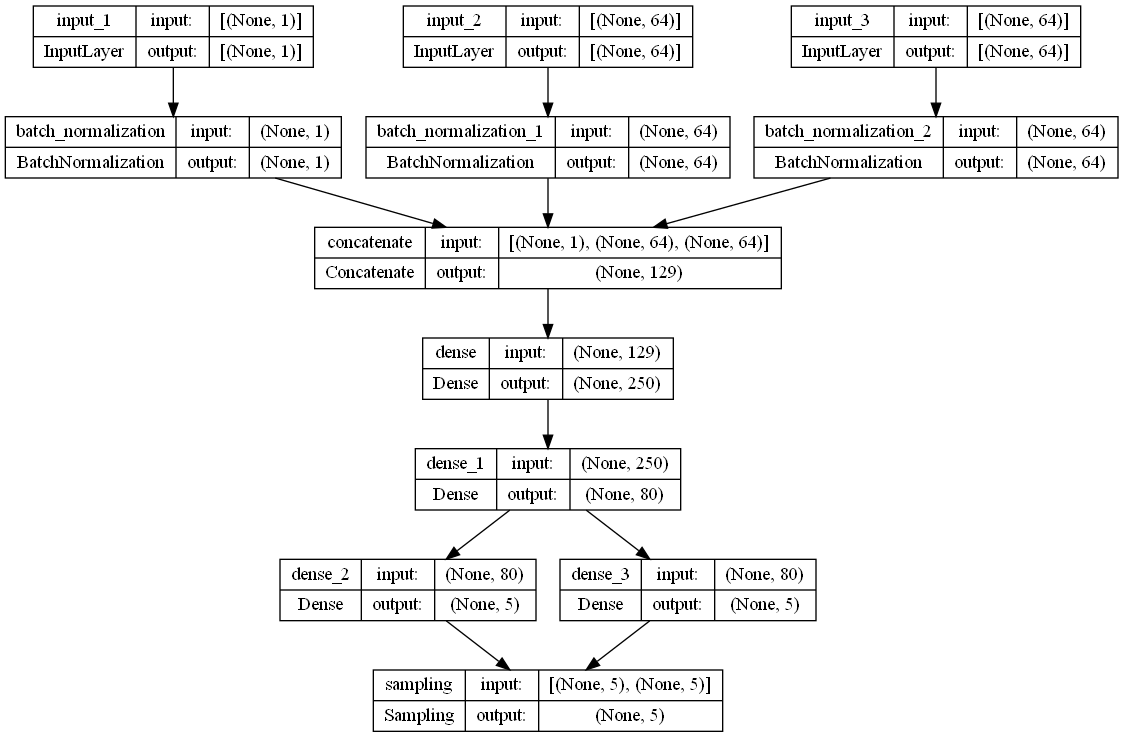

In [26]:
variational_encoder.summary()
K.utils.plot_model(variational_encoder, "vea_enc.png", show_shapes=True)

### decoder artichecture

In [27]:
decoder_inputs = K.layers.Input(shape=[latent_dim])

x_en = K.layers.Dense(N_dec01, activation="relu", kernel_initializer="he_normal")(decoder_inputs)
x_ud = K.layers.Dense(N_dec01, activation="relu", kernel_initializer="he_normal")(decoder_inputs)

outputs_en = K.layers.Dense(2*N_out)(x_en)
outputs_ud = K.layers.Dense(N_out_ud, activation="softmax")(x_ud)

if single_route:
    outputs_r_mu = K.layers.Dense(N_out, activation="softplus")(x_en)
    outputs_r_var = K.layers.Dense(N_out)(x_en)
    outputs_r = K.layers.concatenate([outputs_r_mu, outputs_r_var])
else:
    x_r = K.layers.Dense(N_dec01, activation="relu", kernel_initializer="he_normal")(decoder_inputs)
    outputs_r_mu = K.layers.Dense(N_out, activation="softplus")(x_r)
    outputs_r_var = K.layers.Dense(N_out)(x_r)
    outputs_r = K.layers.concatenate([outputs_r_mu, outputs_r_var])


variational_decoder_en = K.Model(inputs=[decoder_inputs], outputs=[outputs_en])
variational_decoder_ud = K.Model(inputs=[decoder_inputs], outputs=[outputs_ud])
variational_decoder_r = K.Model(inputs=[decoder_inputs], outputs=[outputs_r])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_4 (Dense)             (None, 80)                480       
                                                                 
 dense_6 (Dense)             (None, 2)                 162       
                                                                 
Total params: 642
Trainable params: 642
Non-trainable params: 0
_________________________________________________________________


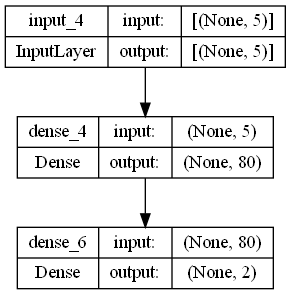

In [28]:
variational_decoder_en.summary()
#K.utils.plot_model(variational_decoder_en, "vea.png", show_shapes=True)
K.utils.plot_model(variational_decoder_en, "vea.png", show_shapes=True)

### $\beta$ VED artichecture

In [31]:
_, _, z = variational_encoder([inputs01, inputs02, inputs03])

reconstructions_e = variational_decoder_en(z)
classfications = variational_decoder_ud(z)
reconstructions_r = variational_decoder_r(z)

variational_ae = K.Model(
    inputs=[inputs01, inputs02, inputs03], 
    outputs=[reconstructions_e, classfications, reconstructions_r])

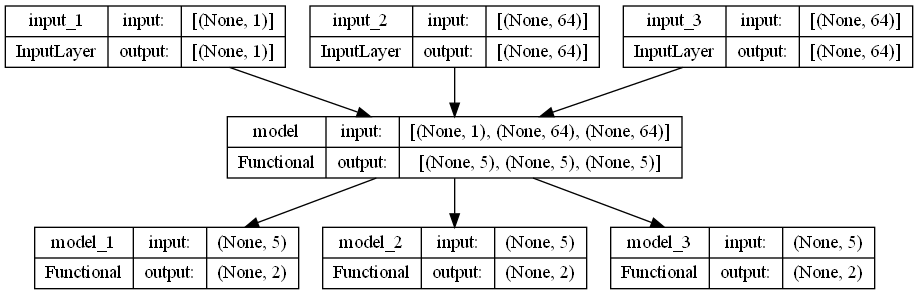

In [32]:
K.utils.plot_model(variational_ae, "vea.png", show_shapes=True)

 ##### add loss directly to the model 

In [33]:
def my_loss(y_true, y_pred):
    p_loss = y_pred[:,1]
    p_loss += tf.square(y_true[:,0]-y_pred[:,0])/tf.exp(y_pred[:,1]) + loss_shift 
    p_loss *= 0.5
    return tf.reduce_mean(p_loss)

In [34]:
def msqe(y_true, y_pred):
    mse_metric = tf.square(y_true[:,0]-y_pred[:,0])
    return tf.reduce_mean(mse_metric)

### compiling model

In [35]:
optimizer = K.optimizers.Nadam(learning_rate = my_lr)

variational_ae.compile(
    loss=(my_loss, "kl_divergence", my_loss), #"mse"), 
    loss_weights=(beta_e, beta_ud, beta_r), # reconstructions and classification
    optimizer=optimizer, 
    metrics=(msqe, "accuracy")
)


### callbacks

In [39]:
tensorboard_cb = K.callbacks.TensorBoard(histogram_freq=500,
                                         write_graph=True,
                                         write_images=True,
                                         update_freq='epoch',
                                         #profile_batch=2,
                                         #embeddings_freq=1,
                                        )


### checking network's 

In [27]:
beta, beta_e, beta_r, m, N_enc01, N_enc02, N_dec01

(0.1, 1.0, 1.0, 60000, 250, 80, 80)

### training

In [42]:
history = variational_ae.fit([X_train01, X_train02, X_train03], 
                             (Y_train01, Y_train02, Y_train03), 
                             epochs = N_epoch, 
                             batch_size = batch_size,
                             callbacks = [tensorboard_cb],
                             validation_data = ([X_valid01, X_valid02, X_valid03], 
                                              (Y_valid01, Y_valid02, Y_valid03))
                           )

211/211 [==============================] - 5s 16ms/step - loss: -1.9118 - model_1_loss: -1.7659 - model_2_loss: 1.1086 - model_3_loss: -0.5268 - model_1_msqe: 0.0101 - model_1_accuracy: 0.0132 - model_2_msqe: 0.4067 - model_2_accuracy: 0.3596 - model_3_msqe: 0.1331 - model_3_accuracy: 0.7021 - my_kl_loss: 0.3809 - val_loss: -1.9569 - val_model_1_loss: -1.8068 - val_model_2_loss: 1.1374 - val_model_3_loss: -0.5265 - val_model_1_msqe: 0.0094 - val_model_1_accuracy: 0.0130 - val_model_2_msqe: 0.4147 - val_model_2_accuracy: 0.3500 - val_model_3_msqe: 0.1352 - val_model_3_accuracy: 0.7033 - val_my_kl_loss: 0.3764


### history plot

In [43]:
history.history.keys()

dict_keys(['loss', 'model_1_loss', 'model_2_loss', 'model_3_loss', 'model_1_msqe', 'model_1_accuracy', 'model_2_msqe', 'model_2_accuracy', 'model_3_msqe', 'model_3_accuracy', 'my_kl_loss', 'val_loss', 'val_model_1_loss', 'val_model_2_loss', 'val_model_3_loss', 'val_model_1_msqe', 'val_model_1_accuracy', 'val_model_2_msqe', 'val_model_2_accuracy', 'val_model_3_msqe', 'val_model_3_accuracy', 'val_my_kl_loss'])

In [44]:
# fig = plt.figure(figsize=(6,6))

# ax = fig.add_subplot(2, 1, 1)
# ax.plot(history.history['loss'], '-k', label="loss")
# ax.plot(history.history['model_1_msqe'], '-r', label="mse_e_loss")
# ax.plot(history.history['model_3_msqe'], '--r', label="mse_r_loss")
# ax.plot(history.history['my_kl_loss'], '-b', label="KL_loss")
# ax.plot(history.history['val_loss'], '-b', label="val_loss")
# ax.legend(loc="upper right")
# #ax.set_yscale('log')
# ax.grid()


# ax = fig.add_subplot(2, 1, 2)
# ax.plot(history.history['model_2_loss'], '-k', label="cat_loss")
# ax.plot(history.history['model_2_accuracy'], '-r', label="cat_accu")
# ax.legend(loc="center right")
# ax.grid()

# beta, beta_e, beta_r

### save/load model

In [45]:
# # save model
# variational_encoder.save(mdl_path_string + "/enc", save_format="tf")
# variational_decoder_en.save(mdl_path_string + "/dec", save_format="tf")
# variational_decoder_ud.save(mdl_path_string + "/decud", save_format="tf")
# variational_decoder_r.save(mdl_path_string + "/decr", save_format="tf")
# variational_ae.save(mdl_path_string + "/whl", save_format="tf")

In [46]:
# # load model
# variational_encoder = tf.keras.models.load_model(mdl_path_string + "/enc")
# variational_decoder_en = tf.keras.models.load_model(mdl_path_string + "/dec")
# variational_decoder_ud = tf.keras.models.load_model(mdl_path_string + "/decud")
# variational_decoder_r = tf.keras.models.load_model(mdl_path_string + "/decr")
# variational_ae = tf.keras.models.load_model(mdl_path_string + "/whl", custom_objects={"my_loss":my_loss, "msqe":msqe})

### tensoboard

In [47]:
#%load_ext tensorboard

#%tensorboard --port 8008 --logdir=./ --host localhost --port 6006
#%tensorboard --bind_all --port 6006 --logdir=./ #--host 127.0.0.1 #--host localhost --port 8008

### set plot properties

In [18]:
plt.rcdefaults()
plt.rcParams['text.usetex'] = True

In [48]:
import scienceplots
plt.style.use(['science', 'no-latex'])

### visualize model result

### test dataset

In [23]:
using_learned_data = False
recursive_jump = False

N_samples = 60000
N_samples_valid = 0

trap_mean = 0
trap_sigma_d = (1/0.3)*kT 
trap_sigma_u = (1/0.3)*kT 

org_mean = 0
org_sigma = trap_sigma_d

trap_alpha_d = 0.3 
trap_alpha_u = 0.3 

trap_Eactv_d = 0.1
trap_Eactv_u = 0.1

if not(using_learned_data):
    if not(recursive_jump):
        origin_energy = origin_energy_generation(N_samples, org_mean, org_sigma)
    else:
        #origin_energy = Y_train01
        origin_energy = Y_pridected_en.reshape([N_samples, 1]) # Y_train01
        
    trap_energy, _ = trap_energy_generation(N_samples, trap_mean, trap_sigma_d, trap_sigma_u, if_exp)
    trap_xyz, trap_r = trap_r_generation(N_samples)
    trap_alpha = trap_alpha_generation(N_samples, trap_alpha_d, trap_alpha_u)
    trap_Eactv = trap_Eactv_generation(N_samples, trap_Eactv_d, trap_Eactv_u)
    X_data01, X_data02, X_data03, Y_data01, Y_data02, Y_data03 = data_generation(origin_energy, trap_energy, trap_r, trap_alpha, trap_Eactv, hopping_type)
    #~~~~ SPLIT
    (X_train01, X_train02, X_train03, #X_train04,
     X_valid01, X_valid02, X_valid03, #X_valid04,
     Y_train01, Y_train02, Y_train03,
     Y_valid01, Y_valid02, Y_valid03) = data_split(N_samples_valid)


Y_pridected = variational_ae([X_train01, X_train02, X_train03])
Y_pridected_en = Y_pridected[0].numpy()
Y_pridected_ud = Y_pridected[1].numpy()
Y_pridected_r = Y_pridected[2].numpy()

Y_pridected_ud.shape

(50000, 2)

### output sampling

In [25]:
use_sampling = 1

if use_sampling:
    Y_pridected_en = Y_pridected_en[:,0] + np.exp(Y_pridected_en[:,1]/2)*np.random.normal(0,1,N_samples)
    Y_pridected_r = Y_pridected_r[:,0] + np.exp(Y_pridected_r[:,1]/2)*np.random.normal(0,1,N_samples)

Y_pridected_en.shape, Y_pridected_r.shape

((50000,), (50000,))

org = -0.030101250491162412
prd = -0.04709075357311748


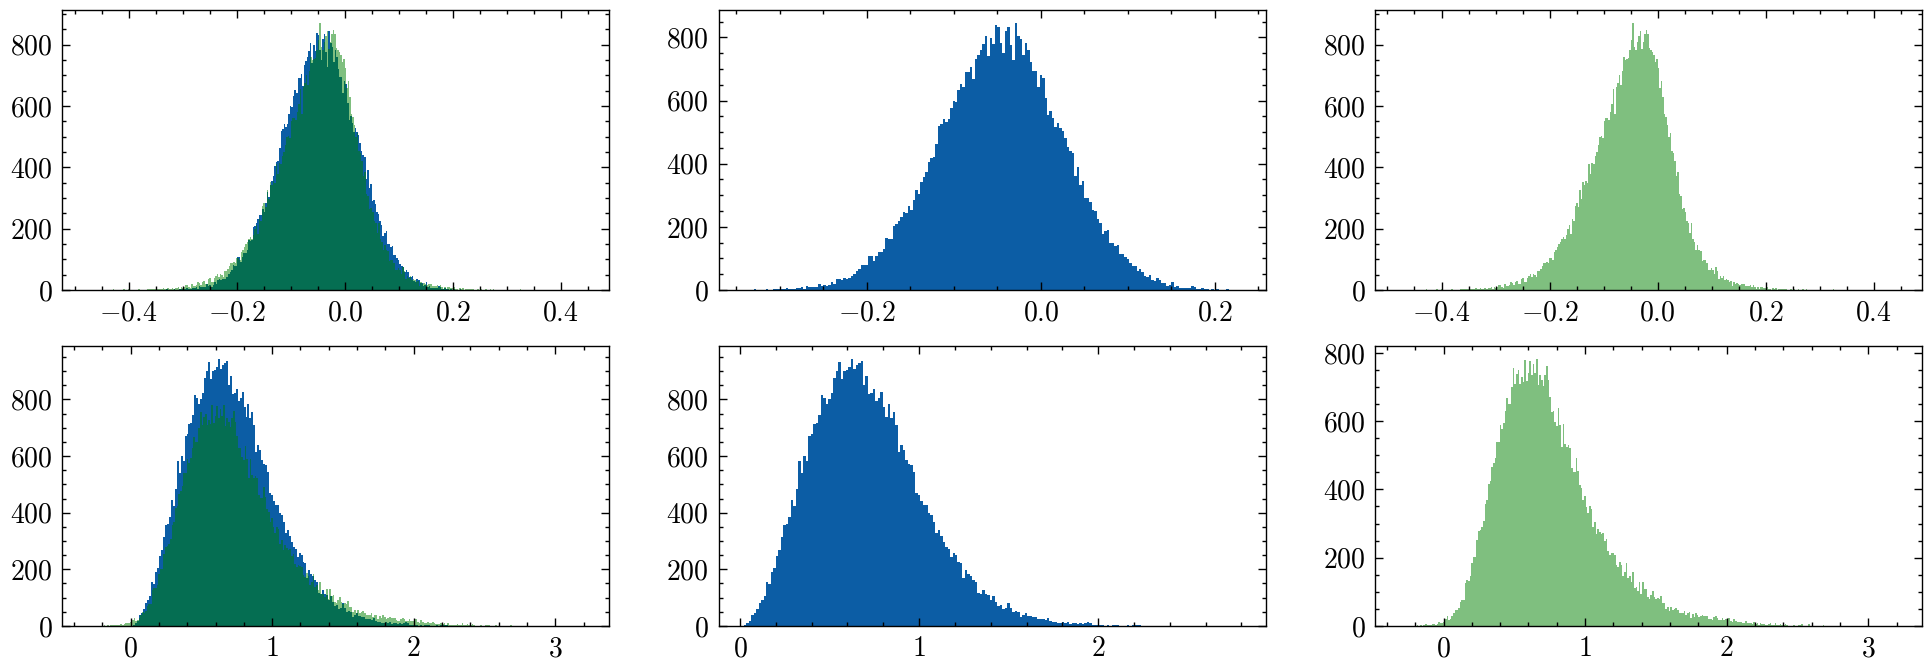

In [26]:
bins = 200
bins_e = 200
bins_r = 200

fig = plt.figure(figsize=(12,4))

#~~~~~~~~~~~~~~~~~~~~ en
ax = fig.add_subplot(2, 3, 1)
org_data = plt.hist(Y_train01[:,0], bins)
if use_sampling: prd_data = plt.hist(Y_pridected_en, bins_e, color = "g", alpha = 0.5)
else:            prd_data = plt.hist(Y_pridected_en[:,0], bins_e, color = "g", alpha = 0.5)

ax = fig.add_subplot(2, 3, 2)
org_data = plt.hist(Y_train01[:,0], bins)

ax = fig.add_subplot(2, 3, 3)
if use_sampling: prd_data = plt.hist(Y_pridected_en, bins_e, color = "g", alpha = 0.5)
else:            prd_data = plt.hist(Y_pridected_en[:,0], bins_e, color = "g", alpha = 0.5)


#~~~~~~~~~~~~~~~~~~~~ r
ax = fig.add_subplot(2, 3, 4)
org_data_r = plt.hist(Y_train03[:,0], bins)
if use_sampling: prd_data_r = plt.hist(Y_pridected_r, bins_r, color = "g", alpha = 0.5)
else:            prd_data_r = plt.hist(Y_pridected_r[:,0], bins_r, color = "g", alpha = 0.5)

ax = fig.add_subplot(2, 3, 5)
org_data_r = plt.hist(Y_train03[:,0], bins)

ax = fig.add_subplot(2, 3, 6)
if use_sampling: prd_data_r = plt.hist(Y_pridected_r, bins_r, color = "g", alpha = 0.5)
else:            prd_data_r = plt.hist(Y_pridected_r[:,0], bins_r, color = "g", alpha = 0.5)

###########
org_E_peak = org_data[1][np.argmax(org_data[0])]
prd_E_peak = prd_data[1][np.argmax(prd_data[0])]

print("org =", org_E_peak)
print("prd =", prd_E_peak)

### Weights

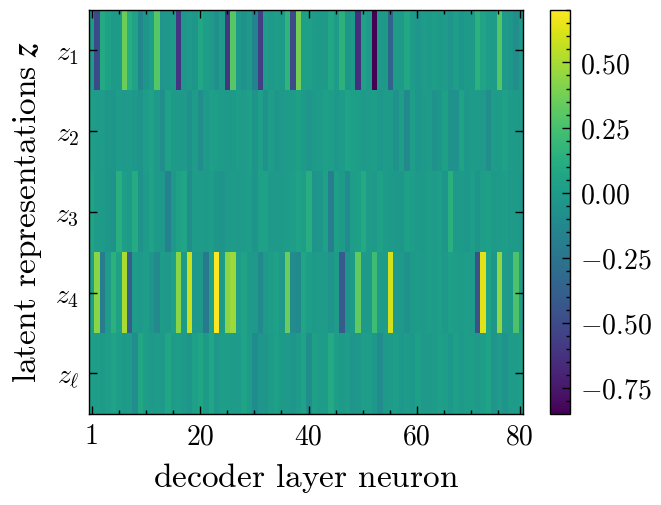

In [811]:
decoder_layares = variational_decoder_en.layers
im = plt.imshow(decoder_layares[1].get_weights()[0], aspect='auto', interpolation='nearest')
plt.ylabel(r'$\text{latent representations } \boldsymbol{z}$', fontsize=12)
plt.xlabel(r"$\text{decoder layer neuron}$", fontsize=12)
plt.colorbar()

plt.gca().set_xticks([0,20,40,60,79])
plt.gca().set_xticklabels([1,20,40,60,80])
plt.gca().set_yticks([0,1,2,3,4])
plt.gca().set_yticklabels([r"$z_1$",r"$z_2$",r"$z_3$",r"$z_4$",r"$z_{\ell}$"])

plt.gca().tick_params(axis='y', which='minor', right=False, left=False)

plt.savefig("w.svg", transparent=True)